In [ ]:
'''
------------------------------------------------------
MLP ENGINE V1.1: DISTINCIONES EN PASOS, PREDICCIONES
------------------------------------------------------

EN ESTA VERSIÓN SE ESTABLECEN DOS PUNTOS QUE SON POSIBLES E IMPORTANTES DE RESALTAR: 
- LA VARIABLE "PASOS" PUEDE SER MODIFICADA PARA ADAPTARSE A LA SEGMENTACÍON Y LA PREPARACIÓN DE LOS DATOS
- LA VARIABLE "TRAINING_PERCENTAGE" HACE REFERENCIA AL PORCENTAJE DE DATOS QUE SE USARÁN PARA ENTRENAMIENTO
- LA VARIABLE "NEURONS" HACE REFERENCIA AL NÚMERO DE NEURONAS QUE CONTEMPLA LA CAPA DE LA RED NEURONAL
- LA VARIABLE "PREDICCIONES" SE DISTINGUE DE "PASOS", YA QUE, EL No. DE PASOS ES INDISTINTO AL No. DE PREDICCIONES
    LA CUAL PUEDE ADAPTARSE DESDE 1, 2, 7, 31, 62, etc días.


'''
import pyodbc
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
# from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')

In [4]:
sql_server = """
DRIVER={ODBC Driver 17 for SQL Server};
server=US3RN4M3;
database=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [6]:
query = """
SELECT 
    CAST(f.OrderDate AS DATE) AS sales_date,
    CAST(SUM(f.OrderQuantity) AS INT) AS TotalVentas
FROM 
    FactInternetSales AS f
WHERE 
    f.OrderDate < '2013-12-01'
    AND f.ProductKey = 214  
GROUP BY 
    CAST(f.OrderDate AS DATE)
ORDER BY 
    CAST(f.OrderDate AS DATE) ASC;
"""

In [8]:
query2 = """
SELECT 
    CAST(f.OrderDate AS DATE) AS sales_date,
    CAST(SUM(f.OrderQuantity) AS INT) AS TotalVentas
FROM 
    FactInternetSales AS f
WHERE 
    f.ProductKey = 214  
GROUP BY 
    CAST(f.OrderDate AS DATE)
ORDER BY 
    CAST(f.OrderDate AS DATE) ASC;
"""

In [9]:
#CONSTANTES

PASOS = 31
TRAINING_PERCENTAGE = 0.7
N_PREDICTIONS = 31
EPOCHS = 100
NEURONS = 31 #Mismo que el de pasos


#NOTAS DE ESTA PARTE: el número de pasos no es correlativo al No. de predicciones
#ya que, las predicciones pudieran ser de 61 días y el No. de pasos siempre serán 31, ya que bajo
#ese proceso se hizo el entrenamiento

In [10]:
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

In [11]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
def create_x_y_train(data):
    #(PC)
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    #(PC)
    values = reframed.values
    
    #debemos obtener el total de datos de entrenamiento
    n_train_days = int(len(values) * TRAINING_PERCENTAGE)
    print("Total de datos: ",int(len(values)))

    #80% - entrenamiento 
    train = values[:n_train_days, :]
    print("entrenamiento: ",len(train))

    #20% - prueba
    test = values[n_train_days:, :]
    print("testing: ",len(test))
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    return x_train, y_train, x_val, y_val, scaler, values

In [14]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(NEURONS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
    model.summary()
    return model

In [15]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model):
    # early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)
    results=model.predict(x_val)

    #Validaciones #1
    plt.scatter(range(len(y_val)),y_val,c='g', label='Valores Reales')
    plt.scatter(range(len(results)),results,c='r', label='Valores Predecidos')
    plt.xlabel('Índice')
    plt.ylabel('Valores(escalados)')
    plt.title('Grafico de dispersión entre Valores reales vs Predecidos ')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Validaciones #2 
    plt.plot(history.history['loss'],label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'],label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Grafico de Pérdidas de Entrenamiento y validación, según el # de Épocas')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Validación #3
    plt.title('Grafico de MSE de acuerdo al # de Épocas')
    plt.plot(history.history['mse'],label='MSE de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Preparamos la data a guardar en metadata
    datetim_e = datetime.now().strftime('%H:%M:%S %d-%m-%Y'), 
    # model_summary = model.summary()
    optimizer_model = model.optimizer.get_config()

    #metadata
    metadata = [
            {
                "TOTAL_DE_DATOS": str(data.size),
                "EPOCH": len(history.history['loss']),
                "FECHA_ENTRENAMIENTO": datetim_e,
                "FECHA_MODIFICACION": datetim_e
            },
            optimizer_model, 
            # model_summary
        ]
    print(metadata)


    #Obtener el 20% de la data
    ultimosDias = data[data.index[int(len(data)*TRAINING_PERCENTAGE)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[PASOS]], axis=1, inplace=True)
    values = reframed.values
    print("Meses registrados: ",len(values))
    x_test = values[len(values)-1:, :]
    print("La cantidad de días son: ",x_test.size)
    
    #Tensor
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    return model, x_test

In [16]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor[0]
    return x_test

In [17]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

Conexion establecida satisfactoriamente
Days_format_detected
            TotalVentas
sales_date             
2012-12-28            2
2012-12-29            2
2012-12-30            2
2012-12-31            4
2013-01-01            2
...                 ...
2013-11-26            8
2013-11-27            8
2013-11-28            8
2013-11-29            5
2013-11-30            5

[328 rows x 1 columns]


C:\Users\JoCel\AppData\Local\Temp\ipykernel_23488\2191846126.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prepData = pd.read_sql_query(query,cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_23488\2191846126.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  historyData = pd.read_sql_query(query2, cursor)
c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 31)          │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,024 (4.00 KB)

 Trainable params: 1,024 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

Total de datos:  284
entrenamiento:  198
testing:  86
(198, 1, 31) (198,) (86, 1, 31) (86,)
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5660 - mse: 0.5193 - val_loss: 0.6463 - val_mse: 0.5979
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5748 - mse: 0.5201 - val_loss: 0.6148 - val_mse: 0.5372
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5655 - mse: 0.4856 - val_loss: 0.5913 - val_mse: 0.4965
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5210 - mse: 0.4397 - val_loss: 0.5703 - val_mse: 0.4618
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4955 - mse: 0.3961 - val_loss: 0.5541 - val_mse: 0.4308
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4834 - mse: 0.3743 - val_loss: 0.5443 - val_mse: 0.4091
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4652 - mse: 0.3571 - val_loss: 0.5328 - val_mse: 0.3892
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4764 - mse: 0.3722 - val_loss: 0.5211 - val

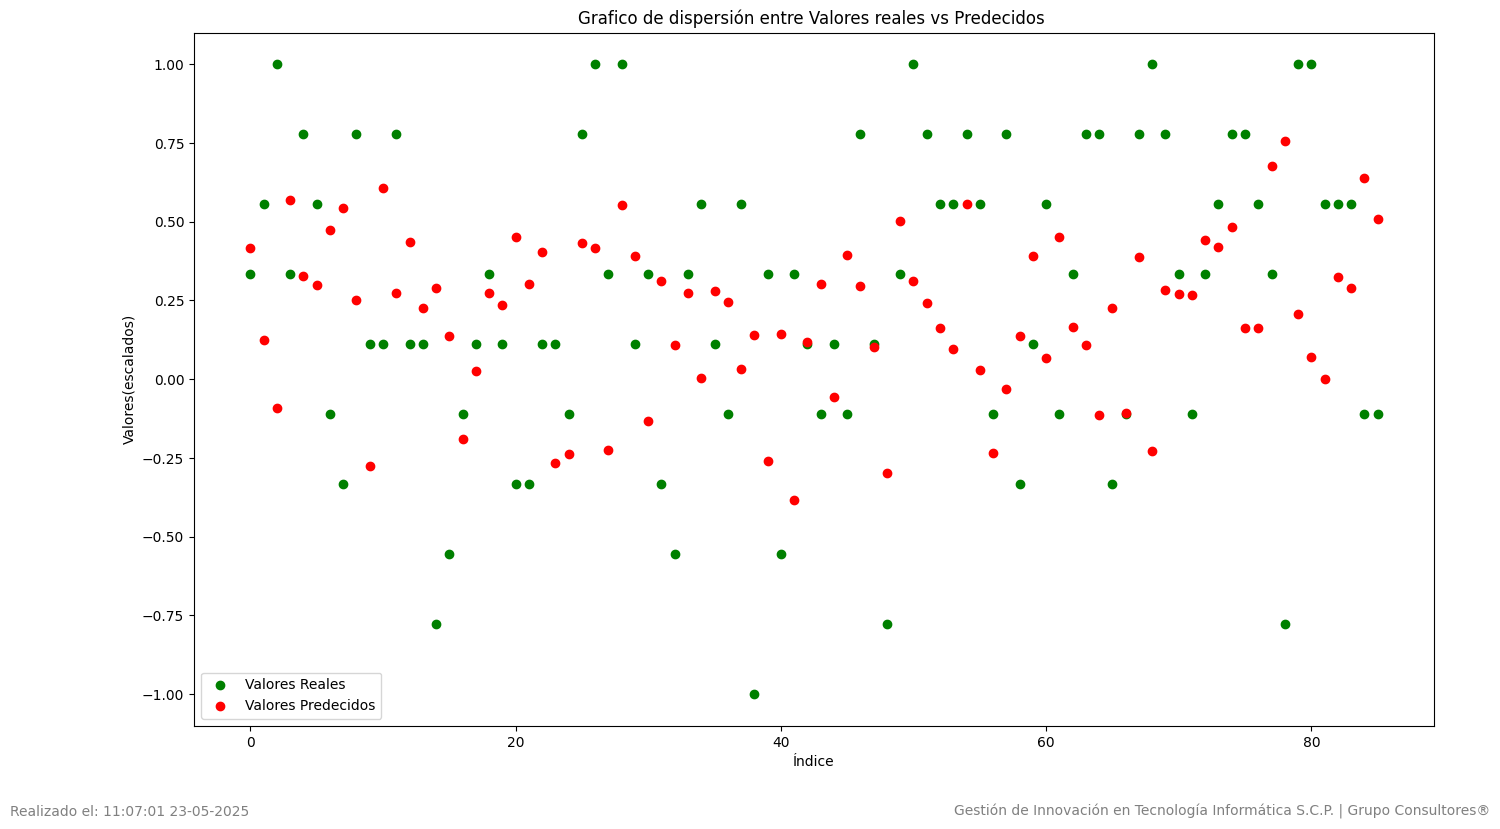

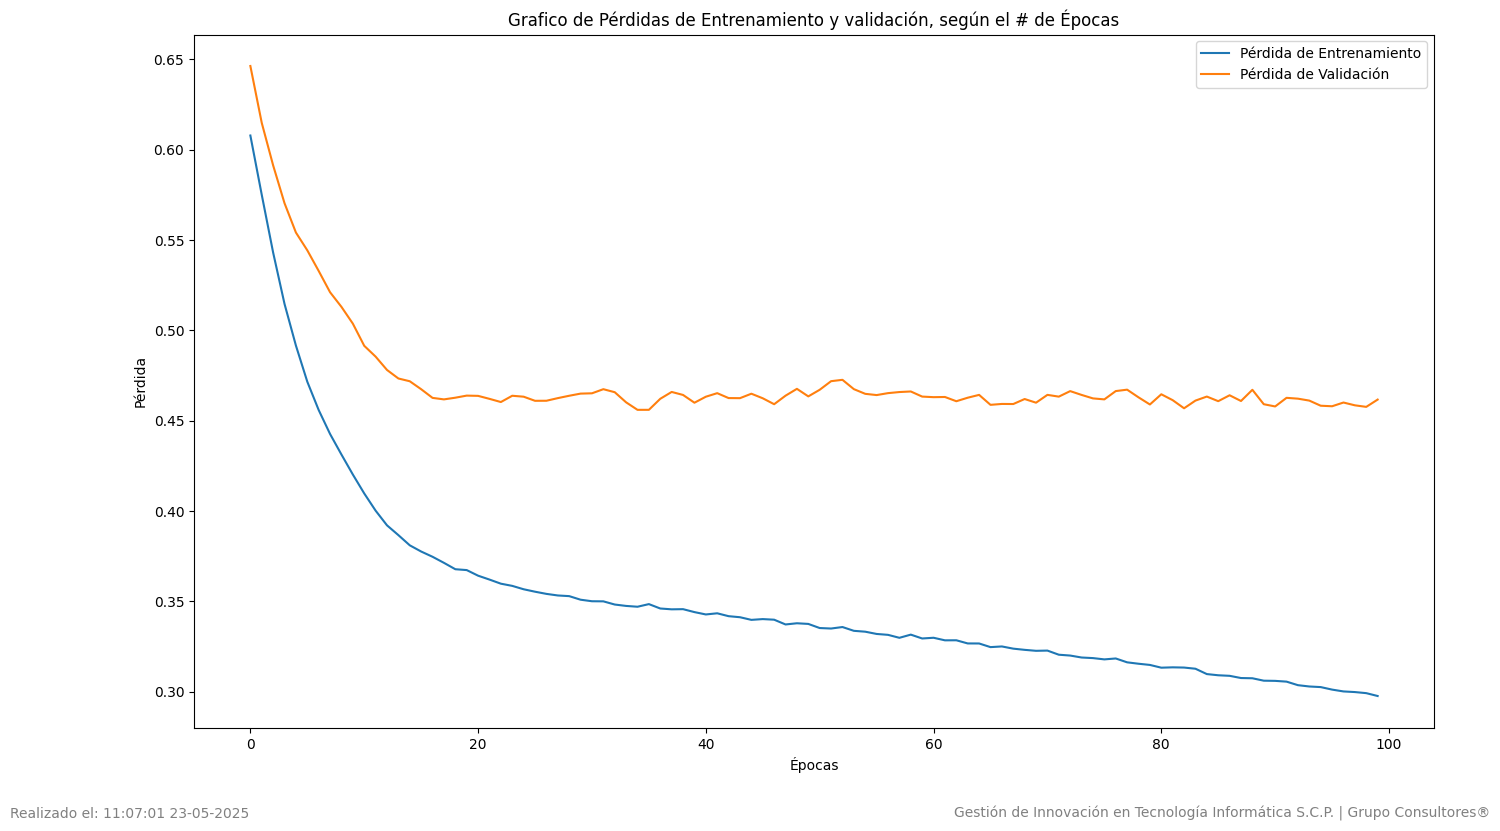

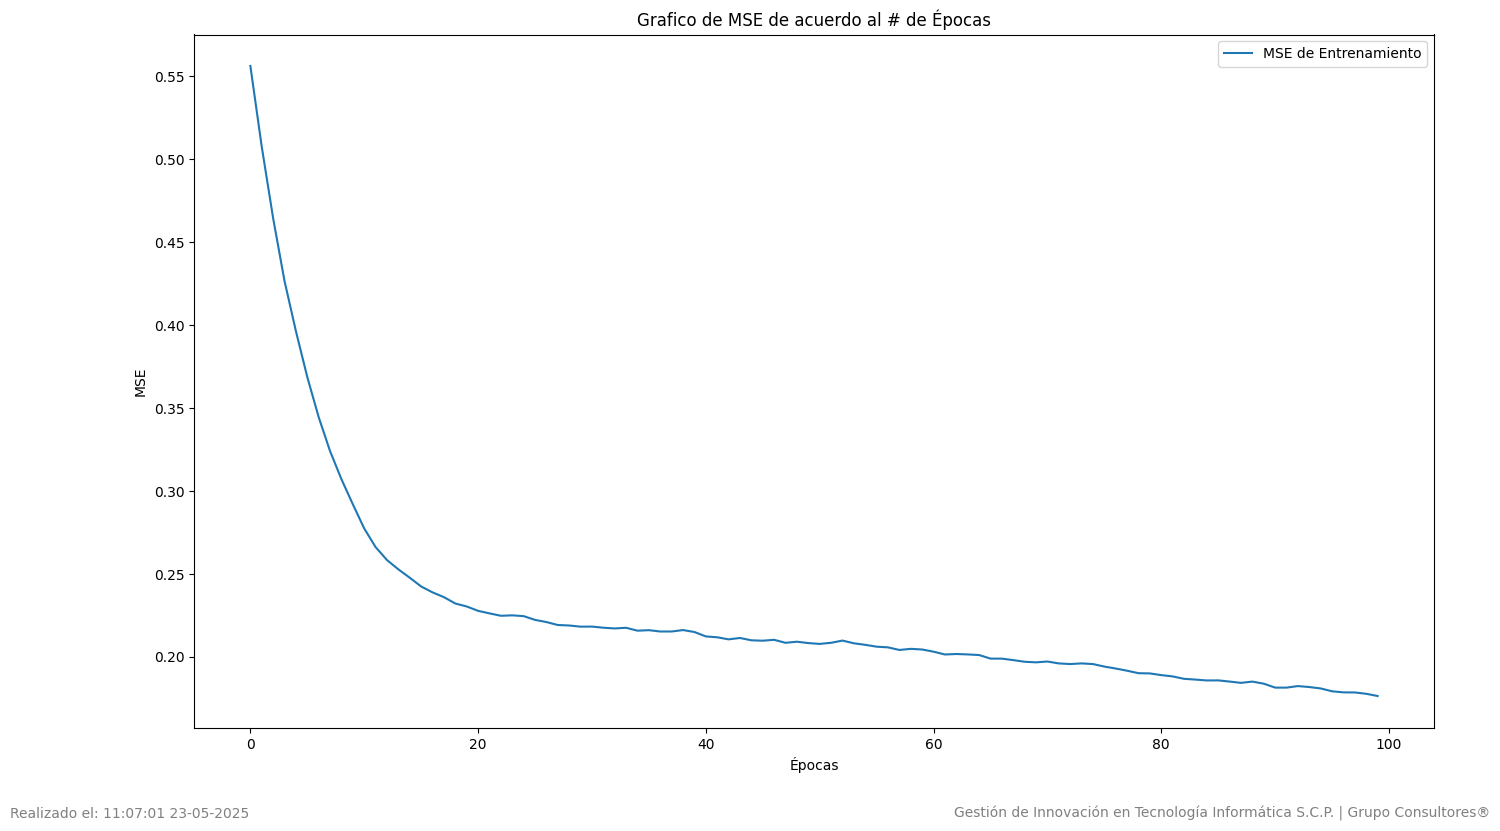

[{'TOTAL_DE_DATOS': '315', 'EPOCH': 100, 'FECHA_ENTRENAMIENTO': ('11:07:01 23-05-2025',), 'FECHA_MODIFICACION': ('11:07:01 23-05-2025',)}, {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}]
Meses registrados:  64
La cantidad de días son:  31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━

In [18]:
#core
with get_sqlconnection(sql_server) as cursor: 
    prepData = pd.read_sql_query(query,cursor)
    historyData = pd.read_sql_query(query2, cursor)

    prepData = set_index_datetime(prepData)
    historyData = set_index_datetime(historyData)

    #Switch the format on days or months
    try: 
        #Si se trata de meses
        first_day = datetime.strptime(prepData.index.min(),'%Y-%m') + relativedelta(months=1)
        last_day = datetime.strptime(prepData.index.max(), '%Y-%m' ) + relativedelta(months=1)
        future_days = [last_day + relativedelta(months=i) for i in range(N_PREDICTIONS)]
        for i in range(len(future_days)):
            future_days[i] = str(future_days[i])[:7]
        print("Month_format_detected")
    except Exception as e: 
        #si se trata de dias
        print("Days_format_detected")
        first_day = prepData.index.min() + timedelta(days=1)
        last_day = prepData.index.max() + timedelta(days=1)
        future_days = [last_day + timedelta(days=i) for i in range(N_PREDICTIONS)]
        for i in range(len(future_days)):
            future_days[i] = str(future_days[i])[:10]
    #END TRY

    future_data = pd.DataFrame(future_days, columns=['fecha'])
    print(prepData)
    model = crear_modeloFF()
    data =[]
    for column in prepData.columns:
        # print(column)
        data = prepData.filter([column])
        data.set_index(prepData.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        #Entonces, convendría guardar x_test con los últimos datos
        copia_test = x_test
        results = []
        for i in range(N_PREDICTIONS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        print("la cantidad de datos son: ",(len(results)))
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)


In [19]:
    future_data

,TotalVentas
fecha,
2013-12-01,7
2013-12-02,4
2013-12-03,6
2013-12-04,6
2013-12-05,6
2013-12-06,7
2013-12-07,8
2013-12-08,7
2013-12-09,5


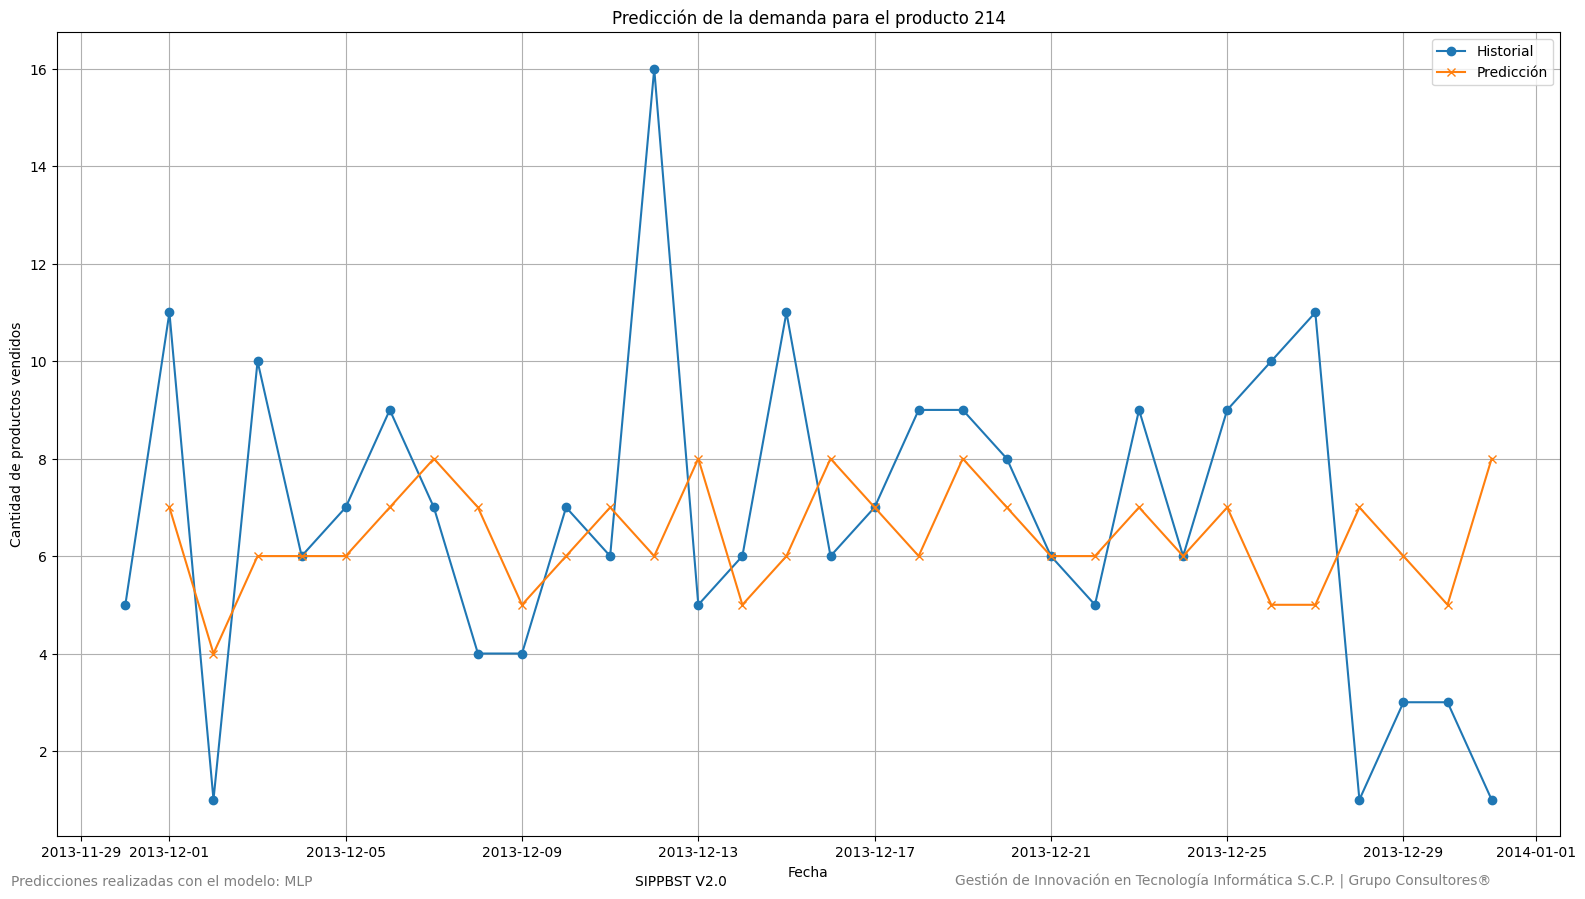

In [20]:
prepData = historyData
prepData.index = pd.to_datetime(historyData.index)
future_data.index = pd.to_datetime(future_data.index)
start_date = '2013-11-30'
end_date = '2013-12-31'

# Filtra los datos por rango de fechas
filtered_data = prepData.loc[start_date:end_date]

# plt.plot(filtered_data.index, filtered_data['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day.year), p1= str(last_day.year-1)), marker='o')
plt.plot(filtered_data.index, filtered_data['TotalVentas'],label='Historial', marker='o')
# plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción {p0}'.format(p0=str(last_day.year)), marker='x')
plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción', marker='x')
xtics = data.index.union(future_data.index)[::10]

plt.xlabel('Fecha')
plt.ylabel('Cantidad de productos vendidos')
plt.title('Predicción de la demanda para el producto {p0}'.format(p0=str(214)))
plt.figtext(0.01,0.01,"Predicciones realizadas con el modelo: MLP",fontsize=10,color="gray")
plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
plt.figtext(0.40,0.01, "SIPPBST V2.0")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()